# Determining Molecular Geometry using noisy quantum computer

## Quantum Variational Algorithm

The goal of a quantum variational algorithm is to find the minimum of an objective function  $g(\theta, x) = \langle \psi(\theta) | H(x) | \psi(\theta)\rangle$ where the state $\psi(\theta)$ is obtained from a parameterized quantum circuit with free parameters $\theta$, and $H(x)$ represents a quantum Hamiltonian. In this notebook, we will take $H(x)$ to be the electronic Hamiltonian of the molecule where $x$ represent the nuclear coordinates of the atoms. With this mapping, the problem at hand boils down to minimizing the energy function 

$$E(\theta, x) = \langle \psi(\theta) | H(x) | \psi(\theta)\rangle$$

through a ___joint___ optimization of parameters $\theta$ and variables $x$. This problem lends itself naturally to the quantum-classical hybrid apparoach, where the a parameterized quantum circuit with parameter $\theta$ prepares the state $\psi(\theta)$ and computes the expectation value of the quantum Hamiltonian $H(x)$ with respect to $\psi(\theta)$. The resulting energy $E(\theta, x)$ then plays the role of an objective function which is then optimized using classical optimization algorithm. In this way, the algorithm first starts with initial values of $\theta$ and $x$ and in each subsequent iterations the algorithm calls for computation of $E(\theta, x)$ and it's gradient using quantum resources followed by update of parameters $(\theta, x)$ using classical optimization algorithm until the convergenec criteria is satisfied. 

We will be using Amazon Braket's __Hybrid Jobs__ feature to perform the quantum-classical optimization described above.

Let's begin by importing important plugins. [PennyLane](https://pennylane.ai/install.html) is a Python library for differentiable programming of quantum computers, allowing you to train a quantum computer the same way as a neural network. Pennylane comes fully integrated with Braket and can be imported directly. We will be using `Pennylane` to setup the model, the underlying Hamiltonian, and simulations. A basic example of running `VQE` on Pennylane can be found [here](https://pennylane.ai/qml/demos/tutorial_vqe/).  

In [29]:
import os
from time import time
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

## Define the model for Trihydrogen Cation $H_3^+$

The molecular Hamiltonian requires number of `electrons`, `number of atoms` and the `total charge`. Here we are simulating $H_3^+$ molecule which has the following values: 

In [30]:
electrons = 2
n_atoms = 3
charge = 1
symbols = ["H", "H", "H"]

Initial guess for the coordinate and add it to the `hyperparameters` to be passed to the algorithm script for a streamlined passing of the parameters. 

In [31]:
coordinates = np.array([0.028, 0.054, 0.0, 0.986, 0.610, 0.0, 1.855, 0.002, 0.0])

Extract number of `qubits` in the model, used to instantiate quantum device. 

Extract number of `qubits` in the model, used to instantiate quantum device can be obtained by calling the `qml.qchem.molecular_hamiltonian` function which returns the Hamiltonian and the number of qubits required. 

In [32]:
hamilt, qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates, charge=1)
print("Number of qubits required:", qubits)

Number of qubits required: 6


We now import the [reference implementation](https://pennylane.ai/qml/demos/tutorial_mol_geo_opt/) of the noise simulation of the algorithm with `shots=0` implemented in Pennylane. In this notebook, we package the implementation in the function `vqe_noiseless()` and define `log_metrics`. This function will then be later decorated with `@hybrid_jobs`

In [33]:
from braket.jobs.metrics import log_metric
from braket.tracking import Tracker
def vqe_noiseless(device, electrons=electrons, charge=charge, symbols=symbols, 
                  coordinates=coordinates, max_iter=40):
    tracker = Tracker().start()

    coordinates = np.array(coordinates, requires_grad=True)

    #Build Molecular Hamiltonian
    hamilt, qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates, charge=charge)
    print("Number of electrons:", electrons, "Symbols:", symbols, "Number of qubits:", qubits)

    def Hamiltonian(x):
        return qml.qchem.molecular_hamiltonian(symbols, x, charge=charge)[0]

    #Variational Quantum Circuit
    hf_state = qml.qchem.hf_state(electrons, qubits)

    # The Parameterized Quantum Circuit to prepare the state
    @qml.qnode(device, interface="autograd")
    def circuit(params, obs, wires):
        qml.BasisState(hf_state, wires=wires)
        qml.DoubleExcitation(params[0], wires=[0, 1, 2, 3])
        qml.DoubleExcitation(params[1], wires=[0, 1, 4, 5])
        return qml.expval(obs)

    # The objective function
    def objective(params, x):
        hamiltonian = Hamiltonian(x)
        return circuit(params, obs=hamiltonian, wires=range(qubits))

    def finite_diff(f, x, delta=0.01):
        """Compute the central-difference finite difference of a function"""
        gradient = []
        for i in range(len(x)):
            shift = np.zeros_like(x)
            shift[i] += 0.5 * delta
            res = (f(x + shift) - f(x - shift)) * delta**-1
            if len(res.coeffs) == 0:
                res = qml.Hamiltonian([0.0], [qml.Identity(0)])
            gradient.append(res)
        return gradient

    def grad_x(params, x):
        grad_h = finite_diff(Hamiltonian, x)
        grad = [circuit(params, obs=obs, wires=range(qubits)) for obs in grad_h]
        return np.array(grad)

    # Select optimizers
    opt_theta = qml.GradientDescentOptimizer(stepsize=0.4)
    opt_x = qml.GradientDescentOptimizer(stepsize=0.8)

    ## Initialize circuit parameters
    theta = np.array([0.0, 0.0], requires_grad=True)
    x = coordinates

    # Factor to convert from Bohrs to Angstroms
    bohr_angs = 0.529177210903

    for n in range(max_iter):
        t1 = time()
        # Optimize the circuit parameters
        theta.requires_grad = True
        x.requires_grad = False
        theta, _ = opt_theta.step(objective, theta, x)

        # Optimize the nuclear coordinates
        x.requires_grad = True
        theta.requires_grad = False
        _, x = opt_x.step(objective, theta, x, grad_fn=grad_x)
        t2 = time()
        # Energy (objective function) and Bond Length
        energy_n = objective(theta, x)
        bond_length_n = np.linalg.norm(x[0:3] - x[3:6]) * bohr_angs
        # Compute the slopes of two bonds
        m1 = (x[4] - x[1])/(x[3] - x[0])
        m2 = (x[7] - x[1])/(x[6] - x[0])
        # Use the slopes computed above to compute the angle between the bonds
        angle_n = np.arctan(np.abs((m1-m2)/(1+m1*m2)))*180/np.pi

        # Track the cost as a metric
        timestamp = time()
        braket_tasks_cost = float(tracker.simulator_tasks_cost() + tracker.qpu_tasks_cost())
        # Tracking walltime per iteration
        log_metric(metric_name="wall-time", value=float(t2 - t1), iteration_number=n)
        # Tracking Braket cost as metric
        log_metric(metric_name="Braket_Cost", value=braket_tasks_cost,iteration_number=n,
            timestamp=timestamp)
        # Value of the objective function as metric
        log_metric(metric_name="Energy", value=energy_n, iteration_number=n,
            timestamp=timestamp)
        # Bond length as metric
        log_metric(metric_name="Bond_Length", value=bond_length_n, iteration_number=n,
            timestamp=timestamp)
        # Bond angle as metric
        log_metric(metric_name="Bond_Angle", value=angle_n, iteration_number=n,
            timestamp=timestamp)

        if n % 4 == 0:
            print(f"Step = {n},  E = {energy_n:.8f} Ha,  bond length = {bond_length_n:.5f} A")

    print("\n" "Ground-state equilibrium geometry")
    print("%s %4s %8s %8s" % ("symbol", "x", "y", "z"))
    for i, atom in enumerate(symbols):
        print(f"  {atom}    {x[3 * i]:.4f}   {x[3 * i + 1]:.4f}   {x[3 * i + 2]:.4f}")

    print("Job completed!!!!!")

    return x

Of course, the function above can be executed just as it is:

In [38]:
device = qml.device("default.qubit", wires=qubits, shots=None)
vqe_noiseless(device, max_iter=1)

Number of electrons: 2 Symbols: ['H', 'H', 'H'] Number of qubits: 6
Metrics - timestamp=1721584250.5399356; wall-time=19.048912048339844; iteration_number=0;
Metrics - timestamp=1721584250.539919; Braket_Cost=0.0; iteration_number=0;
Metrics - timestamp=1721584250.539919; Energy=-1.241831808663133; iteration_number=0;
Metrics - timestamp=1721584250.539919; Bond_Length=0.8344370366247061; iteration_number=0;
Metrics - timestamp=1721584250.539919; Bond_Angle=42.8614196054905; iteration_number=0;
Step = 0,  E = -1.24183181 Ha,  bond length = 0.83444 A

Ground-state equilibrium geometry
symbol    x        y        z
  H    -0.2411   -0.0852   0.0000
  H    0.9591   0.9376   0.0000
  H    2.1510   -0.1864   0.0000
Job completed!!!!!


tensor([-0.24106341, -0.08520532,  0.        ,  0.95907803,  0.93760453,
         0.        ,  2.15098534, -0.18639953,  0.        ], requires_grad=True)

## Amazon Braket Hybrid Jobs

Amazon Braket Hybrid Jobs enanbles you to run hybrid-quantum-classical algorithms that require frequent exchanges between classical and quantum resources. Hybrid Jobs is designed to spinup, use, and release classical resources as they are required so you pay only for what you use. It provides `priority access` to the QPU(s) which means that once a hybrid jobs instance initiates it has uninterrupted access to the QPUs until the jobs is completed. This is particularly beneficial for iterative hybrid algorithms where subsequent tasks depend on the outcomes of prior quantum tasks, such as `Quantum Approximate Optimization Algorithm (QAOA)`, `Variational Quantum Eigensolver (VQE)`, and `Quantum Machine Learning (QML)`. Fruthermore, on certain QPUs, running algorithms using hybrid jobs benefits from  [parametric compilation](https://docs.aws.amazon.com/braket/latest/developerguide/braket-jobs-parametric-compilation.html).

Hybrid Jobs runs an algorithm in a containerized environment. To run a function such as the `run_vqe_hybrid()` in the above example as a Hybrid Jobs, we need to decorate the function to `@hybrid_job` decorator. Then, calling the executing the same function initiate a `hybrid jobs instance`. Let's first import imporant modules and function to run hybrid jobs. 

Let's start by importing `Hybrid Job` and other useful modules.

In [5]:
from braket.jobs import hybrid_job
from braket.tracking import Tracker
from braket.aws import AwsQuantumJob
from braket.jobs.metrics import log_metric

### Noiseless simulation

In the following cell we have decorated the function call `run_vqe_hybrid_noiseless` with `@hybrid_job(...)`. Note that the decorator has a specified quantum device. This is the device to which the `@hybrid_job` will have priority access. 

In [7]:
device_arn = "local:pennylane/default.qubit"

@hybrid_job(device=device_arn)
def run_vqe_hybrid_noiseless(shots=1000, max_iter=40):
    cost_tracker = Tracker().start()

    device = qml.device("default.qubit", wires=qubits, shots=shots)
    print(device.name)
    converged_x = vqe_noiseless(device, max_iter=max_iter)
    cost_tracker.stop()

    # return converged_x
    return {"result": converged_x,
            "quantum task summary": cost_tracker.quantum_tasks_statistics(),
            "quantum task cost": cost_tracker.qpu_tasks_cost() + cost_tracker.simulator_tasks_cost(),
           }

In [138]:
job_noiseless_shots0 = run_vqe_hybrid_noiseless(shots=None, max_iter=10)

In [ ]:
job_shots0 = run_vqe_hybrid_noiseless(shots=None, max_iter=10)
job_shots1k = run_vqe_hybrid_noiseless(shots=1000)

In [82]:
print(job_shots0.arn, job_shots1k.arn)

arn:aws:braket:us-east-1:574945598312:job/0b0530ae-bb9e-4a11-b5a2-3241fcdaa930 arn:aws:braket:us-east-1:574945598312:job/ade14c55-7cce-4671-81cf-2f024a0f38e6


In [81]:
print(job_shots0.name, job_shots1k.name)

run-vqe-hybrid-1720573562888 run-vqe-hybrid-1720573571841


In [8]:
job_shots0 = AwsQuantumJob("arn:aws:braket:us-east-1:574945598312:job/0b0530ae-bb9e-4a11-b5a2-3241fcdaa930")
job_shots1k = AwsQuantumJob("arn:aws:braket:us-east-1:574945598312:job/ade14c55-7cce-4671-81cf-2f024a0f38e6")

##### Metric for Noiseless simulations

In [39]:
def retrieve_metrics(job):
    metrics = job.metrics()
    idx = metrics['iteration_number']
    time = metrics['time']
    energy = metrics['Energy']
    angle = metrics['Bond_Angle']
    length = metrics['Bond_Length']

    e = [ x for x in metrics['Energy'] if x!=None]
    e.reverse()
    a = [ x for x in metrics['Bond_Angle'] if x!=None]
    a.reverse()
    l = [ x for x in metrics['Bond_Length'] if x!=None]
    l.reverse()
    t = [ x for x in metrics['time'] if x!=None]
    t.reverse()
    return (e, a, l, t)

In [40]:
# Metrics for shots = 0
e_shots0, a_shots0, l_shots0, t_shots0 = retrieve_metrics(job_shots0)
# Metrics for shots = 1000
e_shots1k, a_shots1k, l_shots1k, t_shots1k = retrieve_metrics(job_shots1k)

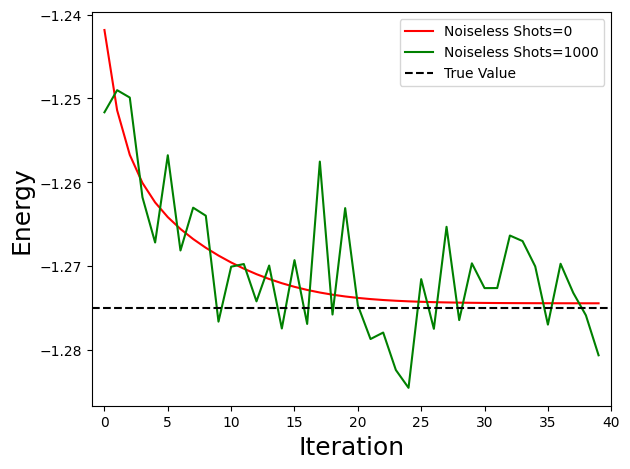

In [17]:
plt.plot(e_shots0, 'r')
plt.plot(e_shots1k, 'g')
plt.axhline(y = -1.275, color = 'black', linestyle = '--') 
plt.legend(["Noiseless Shots=0", "Noiseless Shots=1000", "True Value"])
plt.xlabel('Iteration', fontsize=18)
plt.ylabel('Energy', fontsize=18, rotation=90)
plt.xlim([-1,40])
# plt.ylim([0.8,1.2])
plt.tight_layout()
plt.savefig("energy_iteration.png")
plt.show()

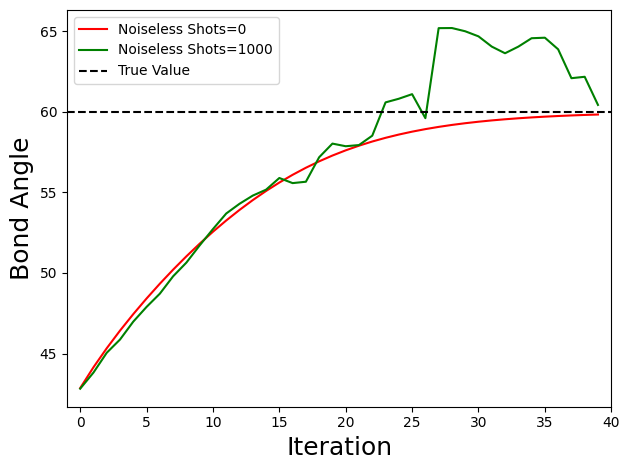

In [18]:
plt.plot(a_shots0, 'r')
plt.plot(a_shots1k, 'g')
plt.axhline(y = 60, color = 'black', linestyle = '--') 
plt.legend(["Noiseless Shots=0", "Noiseless Shots=1000", "True Value"])
plt.xlabel('Iteration', fontsize=18)
plt.ylabel('Bond Angle', fontsize=18, rotation=90)
plt.xlim([-1,40])
# plt.ylim([0.8,1.2])
plt.tight_layout()
plt.savefig("angle_iteration.png")
plt.show()

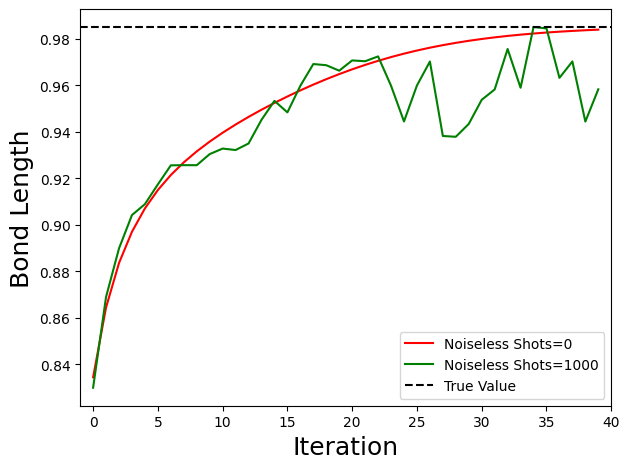

In [19]:
plt.plot(l_shots0, 'r')
plt.plot(l_shots1k, 'g')
plt.axhline(y = 0.985, color = 'black', linestyle = '--') 
plt.legend(["Noiseless Shots=0", "Noiseless Shots=1000", "True Value"])
plt.xlabel('Iteration', fontsize=18)
plt.ylabel('Bond Length', fontsize=18, rotation=90)
plt.xlim([-1,40])
# plt.ylim([0.8,1.2])
plt.tight_layout()
plt.savefig("length_iteration.png")
plt.show()

## Noise Model

In [142]:
from braket.aws import AwsDevice
from braket.circuits import Circuit, Gate
from braket.devices import Devices, LocalSimulator
from braket.circuits.noise_model import GateCriteria, NoiseModel, ObservableCriteria
from braket.circuits.noises import AmplitudeDamping, BitFlip, Depolarizing, PhaseDamping, TwoQubitDepolarizing

In [ ]:
from braket.aws import AwsDevice
from braket.circuits import Circuit, Gate
from braket.devices import Devices, LocalSimulator
from braket.circuits.noise_model import GateCriteria, NoiseModel, ObservableCriteria
from braket.circuits.noises import AmplitudeDamping, BitFlip, Depolarizing, PhaseDamping, TwoQubitDepolarizing

In [143]:
garnet = AwsDevice("arn:aws:braket:eu-north-1::device/qpu/iqm/Garnet")

In [92]:
one_qubit_specs = garnet.properties.dict()['provider']['properties']['one_qubit']
two_qubit_specs = garnet.properties.dict()['provider']['properties']['two_qubit']

In [144]:
one_qubit_specs['1']

{'f1Q_simultaneous_RB': 0.999224399072596,
 'f1Q_simultaneous_RB_std_err': 1.6274738154612528e-05,
 'fRO': 0.98765,
 'T1': 2.2654151135968788e-05,
 'T1_std_err': 3.1970660039657487e-06,
 'T2_echo': 2.000612007570798e-05,
 'T2_echo_std_err': 1.6518666551940017e-06,
 'T2': 8.575729003112496e-06,
 'T2_std_err': 4.7592227634631867e-07}

In [145]:
two_qubit_specs['1-2']

{'fCZ': 0.9946329983251951,
 'fCZ_std_err': 0.0007994320038694208,
 'f2Q_simultaneous_RB_Clifford': 0.9821155215791355,
 'f2Q_simultaneous_RB_Clifford_std_err': 0.0004800502043864306}

In [146]:
gate_time_1q = 32e-9
gate_time_2q = 60e-9

##### One Qubit Noise

In [147]:
noise_model = NoiseModel()

for i in range(len(one_qubit_specs)):
    specs = one_qubit_specs[str(i+1)]

    # T1: Thermal relaxation time 
    T1 = specs['T1']
    damping_prob = 1 - np.exp(-(gate_time_1q / T1))
    noise_model.add_noise(AmplitudeDamping(damping_prob), GateCriteria(qubits=int(i)))

    # T2: The dephasing time
    T2 = specs['T2']
    dephase_prob = 1 - np.exp(-(gate_time_1q / T2))
    noise_model.add_noise(PhaseDamping(dephase_prob), GateCriteria(qubits=int(i)))

    # Fidelity (sRB): Single-qubit simultaneous randomized benchmarking fidelities.
    depol_rate = 1 - specs["f1Q_simultaneous_RB"]
    noise_model.add_noise(Depolarizing(depol_rate), GateCriteria(qubits=int(i)))

    # Readout fidelity: Single-qubit readout fidelities
    readout_rate = 1 - specs["fRO"]
    noise_model.add_noise(BitFlip(readout_rate), ObservableCriteria(qubits=int(i)))

In [148]:
num_params = sum(len(item.noise.parameters) for item in noise_model.instructions)
print("Total number of terms in noise_model instructions:", len(noise_model.instructions))
print("Total number of parameters in the noise_model:", num_params)

Total number of terms in noise_model instructions: 80
Total number of parameters in the noise_model: 80


##### Two Qubit noise

In [149]:
two_qubit_pairs = list(two_qubit_specs.keys())

In [151]:
for pair, params in two_qubit_specs.items():

    q0, q1 = (int(item) for item in two_qubit_pairs[0].split("-"))

    if "fCZ" in params:
        cz_rate = 1 - params["fCZ"]
        noise_model.add_noise(
            TwoQubitDepolarizing(cz_rate), GateCriteria(Gate.CZ, [(q0, q1), (q1, q0)])
        )

In [152]:
num_params = sum(len(item.noise.parameters) for item in noise_model.instructions)
print(f"Number of terms in noise model is: {len(noise_model.instructions)}")
print(f"Number of parameters in noise model is: {num_params}")

Number of terms in noise model is: 140
Number of parameters in noise model is: 140


## Simulation with Noise

In [153]:
device_arn = "local:braket/braket.local.qubit"

@hybrid_job(device=device_arn)
def run_vqe_hybrid(noise_model=None, shots=1000, max_iter=40):
    cost_tracker = Tracker().start()

    if noise_model != None:
        def custom_cnot(wires, **_):
            return [qml.Hadamard(wires=wires[1]),
                qml.CZ(wires=[wires[0], wires[1]]),
                qml.Hadamard(wires=wires[1])
                ]
        custom_decomps = {qml.CNOT: custom_cnot}
        backend = "braket_dm"
    else:
        custom_decomps = None
        backend = "braket_sv"

    print("Using custom_decomps:", custom_decomps)

    device = qml.device("braket.local.qubit", backend=backend, 
                        wires=qubits, noise_model=noise_model,
                        custom_decomps=custom_decomps, shots=shots)

    print(device.name)
    converged_x = vqe_noiseless(device, max_iter=max_iter)
    cost_tracker.stop()

    # return converged_x
    return {"result": converged_x,
            "quantum task summary": cost_tracker.quantum_tasks_statistics(),
            "quantum task cost": cost_tracker.qpu_tasks_cost() + cost_tracker.simulator_tasks_cost(),
           }

### Noisy Simulation

In [126]:
job_noise = run_vqe_hybrid(shots=1000, noise_model=noise_model)

In [327]:
print(job_noise.arn)

arn:aws:braket:us-east-1:574945598312:job/06fd9b4f-baad-41b8-9037-87dde6686f94 arn:aws:braket:us-east-1:574945598312:job/e3f1fcaf-75fd-481f-a180-879bfed5282d


In [20]:
job_noise = AwsQuantumJob("arn:aws:braket:us-east-1:574945598312:job/06fd9b4f-baad-41b8-9037-87dde6686f94")

##### Metrics for Noisy simulation

In [41]:
e_noise, a_noise, l_noise, t_noise = retrieve_metrics(job_noise)

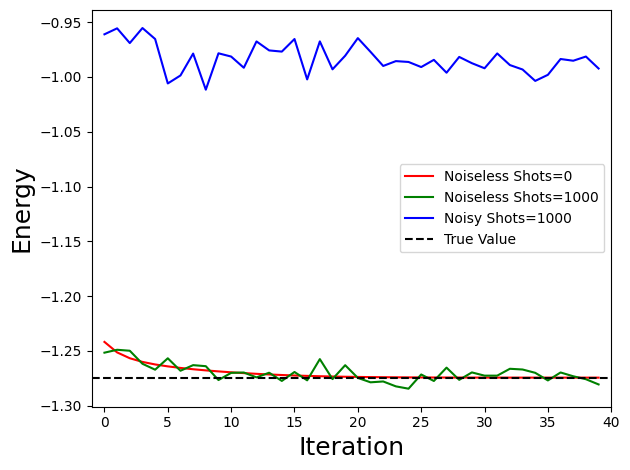

In [22]:
plt.plot(e_shots0, 'r')
plt.plot(e_shots1k, 'g')
plt.plot(e_noise, 'b')
plt.axhline(y = -1.2744, color = 'black', linestyle = '--') 
plt.legend(["Noiseless Shots=0", "Noiseless Shots=1000", "Noisy Shots=1000", "True Value"])
plt.xlabel('Iteration', fontsize=18)
plt.ylabel('Energy', fontsize=18, rotation=90)
plt.xlim([-1,40])
# plt.ylim([0.8,1.2])
plt.tight_layout()
plt.savefig("energy_iteration_withnoiseonly.png")
plt.show()

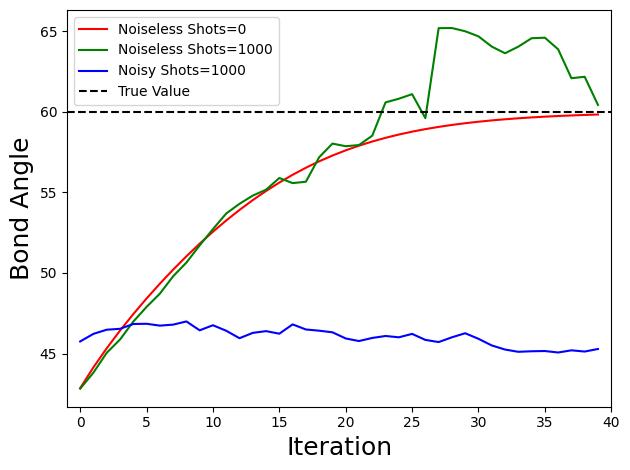

In [152]:
plt.plot(a_shots0, 'r')
plt.plot(a_shots1k, 'g')
plt.plot(a_noise, 'b')
plt.axhline(y = 60, color = 'black', linestyle = '--') 
plt.legend(["Noiseless Shots=0", "Noiseless Shots=1000", "Noisy Shots=1000", "True Value"])
plt.xlabel('Iteration', fontsize=18)
plt.ylabel('Bond Angle', fontsize=18, rotation=90)
plt.xlim([-1,40])
# plt.ylim([0.8,1.2])
plt.tight_layout()
plt.savefig("angle_iteration_withnoiseonly.png")
plt.show()

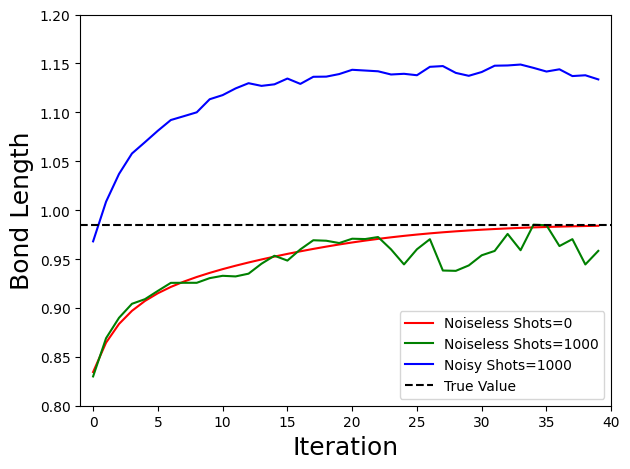

In [121]:
plt.plot(l_shots0, 'r')
plt.plot(l_shots1k, 'g')
plt.plot(l_noise, 'b')
plt.axhline(y = 0.985, color = 'black', linestyle = '--') 
plt.legend(["Noiseless Shots=0", "Noiseless Shots=1000", "Noisy Shots=1000", "True Value"])
plt.xlabel('Iteration', fontsize=18)
plt.ylabel('Bond Length', fontsize=18, rotation=90)
plt.xlim([-1,40])
plt.ylim([0.8,1.2])
plt.tight_layout()
plt.savefig("length_iteration_withnoiseonly.png")
plt.show()

### Implementing Zero Noise Extrapolation

<div>
<img src="zne.png" width="500"/>
</div>

In [101]:
from mitiq.zne.inference import RichardsonFactory
from mitiq.zne.scaling import fold_global as folding

def vqe(device, electrons=electrons, charge=charge, symbols=symbols, 
        coordinates=coordinates, zne=False, max_iter=40):
    cost_tracker = Tracker().start()

    print("Job started!!!!!")
    print("Device selected:", device)
    coordinates = np.array(coordinates, requires_grad=True)

    #Build Molecular Hamiltonian
    hamilt, qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates, charge=charge)
    print("Number of electrons:", electrons, "Symbols:", symbols, "Number of qubits:", qubits)

    def Hamiltonian(x):
        return qml.qchem.molecular_hamiltonian(symbols, x, charge=charge)[0]

    #Variational Quantum Circuit
    hf_state = qml.qchem.hf_state(electrons, qubits)

    # The Parameterized Quantum Circuit to prepare the state
    @qml.qnode(device, interface="autograd")
    def circuit(params, obs, wires):
        qml.BasisState(hf_state, wires=wires)
        qml.DoubleExcitation(params[0], wires=[0, 1, 2, 3])
        qml.DoubleExcitation(params[1], wires=[0, 1, 4, 5])
        return qml.expval(obs)

    if zne:
        extrapolate = RichardsonFactory.extrapolate
        scale_factors = [1, 3, 5]
        circuit = qml.transforms.mitigate_with_zne(circuit, scale_factors, folding, extrapolate)
        print("Using Mitiq for ZNE = ", zne)

    # The objective function
    def objective(params, x):
        hamiltonian = Hamiltonian(x)
        return circuit(params, obs=hamiltonian, wires=range(qubits))

    def finite_diff(f, x, delta=0.01):
        """Compute the central-difference finite difference of a function"""
        gradient = []
        for i in range(len(x)):
            shift = np.zeros_like(x)
            shift[i] += 0.5 * delta
            res = (f(x + shift) - f(x - shift)) * delta**-1
            if len(res.coeffs) == 0:
                res = qml.Hamiltonian([0.0], [qml.Identity(0)])
            gradient.append(res)
        return gradient

    def grad_x(params, x):
        grad_h = finite_diff(Hamiltonian, x)
        grad = [circuit(params, obs=obs, wires=range(qubits)) for obs in grad_h]
        return np.array(grad)

    # Select optimizers
    opt_theta = qml.GradientDescentOptimizer(stepsize=0.4)
    opt_x = qml.GradientDescentOptimizer(stepsize=0.8)

    ## Initialize circuit parameters
    theta = np.array([0.0, 0.0], requires_grad=True)
    x = coordinates

    # Factor to convert from Bohrs to Angstroms
    bohr_angs = 0.529177210903

    for n in range(max_iter):
        t1 = time()
        # Optimize the circuit parameters
        theta.requires_grad = True
        x.requires_grad = False
        theta, _ = opt_theta.step(objective, theta, x)

        if n==0:
            print("Pennylane Circuit is")
            print(device.circuit)

        # Optimize the nuclear coordinates
        x.requires_grad = True
        theta.requires_grad = False
        _, x = opt_x.step(objective, theta, x, grad_fn=grad_x)
        t2 = time()
        # Energy (objective function) and Bond Length
        energy_n = objective(theta, x)
        bond_length_n = np.linalg.norm(x[0:3] - x[3:6]) * bohr_angs
        # Compute the slopes of two bonds
        m1 = (x[4] - x[1])/(x[3] - x[0])
        m2 = (x[7] - x[1])/(x[6] - x[0])
        # Use the slopes computed above to compute the angle between the bonds
        angle_n = np.arctan(np.abs((m1-m2)/(1+m1*m2)))*180/np.pi

        # Track the cost as a metric
        timestamp = time()
        braket_tasks_cost = float(cost_tracker.simulator_tasks_cost() 
                                  + cost_tracker.qpu_tasks_cost())
        # Tracking walltime per iteration
        log_metric(metric_name="wall-time", value=float(t2 - t1), iteration_number=n)
        # Tracking Braket cost as metric
        log_metric(metric_name="Braket_Cost", value=braket_tasks_cost,iteration_number=n,
            timestamp=timestamp)
        # Value of the objective function as metric
        log_metric(metric_name="Energy", value=energy_n, iteration_number=n,
            timestamp=timestamp)
        # Bond length as metric
        log_metric(metric_name="Bond_Length", value=bond_length_n, iteration_number=n,
            timestamp=timestamp)
        # Bond angle as metric
        log_metric(metric_name="Bond_Angle", value=angle_n, iteration_number=n,
            timestamp=timestamp)

        if n % 4 == 0:
            print(f"Step = {n},  E = {energy_n:.8f} Ha,  bond length = {bond_length_n:.5f} A")

    print("\n" "Ground-state equilibrium geometry")
    print("%s %4s %8s %8s" % ("symbol", "x", "y", "z"))
    for i, atom in enumerate(symbols):
        print(f"  {atom}    {x[3 * i]:.4f}   {x[3 * i + 1]:.4f}   {x[3 * i + 2]:.4f}")

    print("Job completed!!!!!")

    return x

In [174]:
image_uri = "574945598312.dkr.ecr.us-east-1.amazonaws.com/amazon-braket-vqe-docker:latest"

In [175]:
device_arn = "local:braket/braket.local.qubit"

@hybrid_job(device=device_arn, image_uri=image_uri)
def run_vqe_hybrid_zne(zne=False, noise_model=None, shots=1000, max_iter=40):
    cost_tracker = Tracker().start()

    if noise_model != None:
        def custom_cnot(wires, **_):
            return [qml.Hadamard(wires=wires[1]),
                qml.CZ(wires=[wires[0], wires[1]]),
                qml.Hadamard(wires=wires[1])
                ]
        custom_decomps = {qml.CNOT: custom_cnot}
        backend = "braket_dm"
    else:
        custom_decomps = None
        backend = "braket_sv"

    print("Using custom_decomps:", custom_decomps)
    print("ZNE: ", zne)

    device = qml.device("braket.local.qubit", backend=backend, 
                        wires=qubits, noise_model=noise_model,
                        custom_decomps=custom_decomps, shots=shots)

    print(device.name)
    converged_x = vqe(device, max_iter=max_iter)
    cost_tracker.stop()

    # return converged_x
    return {"result": converged_x,
            "quantum task summary": cost_tracker.quantum_tasks_statistics(),
            "quantum task cost": cost_tracker.qpu_tasks_cost() + cost_tracker.simulator_tasks_cost(),
           }

Skipping python version validation, make sure versions match between local environment and container.


In [177]:
job_zne = run_vqe_hybrid_zne(shots=1000, noise_model=noise_model, zne=True)

In [ ]:
job_zne = run_vqe_hybrid(shots=1000, noise_model=noise_model, zne=True)
job_zne_5k = run_vqe_hybrid(shots=5000, noise_model=noise_model, zne=True)

In [255]:
print(job_zne.name, job_zne.arn)

run-vqe-hybrid-1720573574905 arn:aws:braket:us-east-1:574945598312:job/ab17e56c-e19e-4287-a98a-0a98b9df6348


In [23]:
job_zne = AwsQuantumJob("arn:aws:braket:us-east-1:574945598312:job/ab17e56c-e19e-4287-a98a-0a98b9df6348")

In [155]:
print(job_zne.arn)

arn:aws:braket:us-east-1:574945598312:job/ab17e56c-e19e-4287-a98a-0a98b9df6348


Metrics for ZNE

In [42]:
e_zne, a_zne, l_zne, t_zne = retrieve_metrics(job_zne)

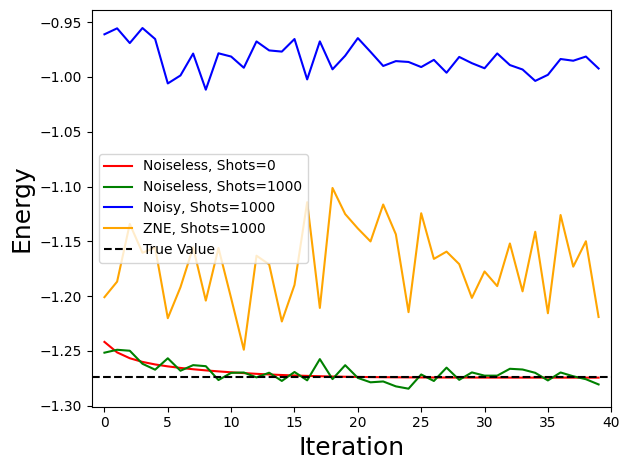

In [25]:
plt.plot(e_shots0, 'r')
plt.plot(e_shots1k, 'g')
plt.plot(e_noise, 'b')
plt.plot(e_zne, 'orange')
plt.axhline(y = -1.274, color = 'black', linestyle = '--') 
plt.legend(["Noiseless, Shots=0", "Noiseless, Shots=1000", 
            "Noisy, Shots=1000", 
            "ZNE, Shots=1000", "True Value"])
plt.xlabel('Iteration', fontsize=18)
plt.ylabel('Energy', fontsize=18, rotation=90)
plt.xlim([-1,40])
# plt.ylim([0.8,1.2])
plt.tight_layout()
plt.savefig("energy_iteration_withZNE.png")
plt.show()

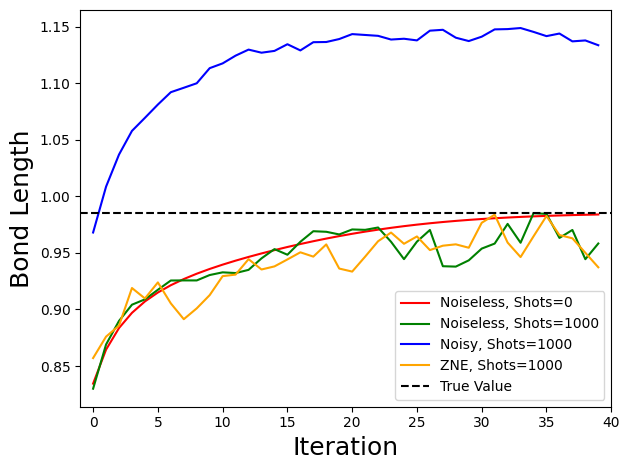

In [158]:
plt.plot(l_shots0, 'r')
plt.plot(l_shots1k, 'g')
plt.plot(l_noise, 'b')
# plt.plot(l_noise_5k, 'black')
plt.plot(l_zne, 'orange')
plt.axhline(y = 0.985, color = 'black', linestyle = '--') 
plt.legend(["Noiseless, Shots=0", "Noiseless, Shots=1000", 
            "Noisy, Shots=1000", 
            "ZNE, Shots=1000", "True Value"])
plt.xlabel('Iteration', fontsize=18)
plt.ylabel('Bond Length', fontsize=18, rotation=90)
plt.xlim([-1,40])
# plt.ylim([0.8,1.2])
plt.tight_layout()
plt.savefig("length_iteration_withZNE.png")
plt.show()

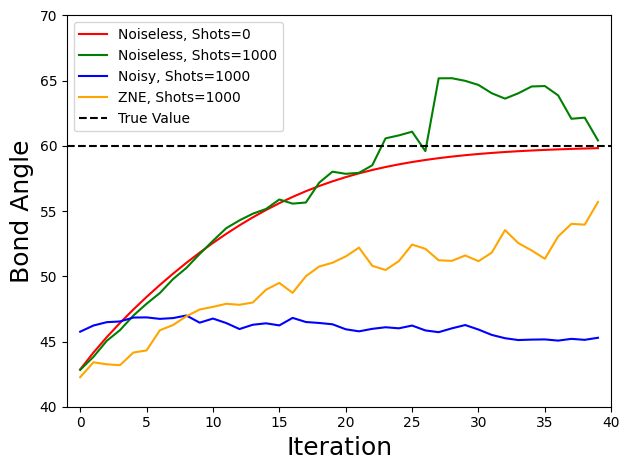

In [159]:
plt.plot(a_shots0, 'r')
plt.plot(a_shots1k, 'g')
plt.plot(a_noise, 'b')
# plt.plot(a_noise_5k, 'black')
plt.plot(a_zne, 'orange')
plt.axhline(y = 60, color = 'black', linestyle = '--') 
plt.legend(["Noiseless, Shots=0", "Noiseless, Shots=1000", 
            "Noisy, Shots=1000", 
            "ZNE, Shots=1000", "True Value"])
plt.xlabel('Iteration', fontsize=18)
plt.ylabel('Bond Angle', fontsize=18, rotation=90)
plt.xlim([-1,40])
plt.ylim([40,70])
plt.tight_layout()
plt.savefig("angle_iteration_withZNE.png")
plt.show()

In [56]:
times = list([np.mean(t_shots0), np.mean(t_shots1k), np.mean(t_noise), np.mean(t_zne)])

In [66]:
xtics = ["Noiseless, Shots=0", "Noiseless, Shots=1000", "Noisy", "ZNE"]

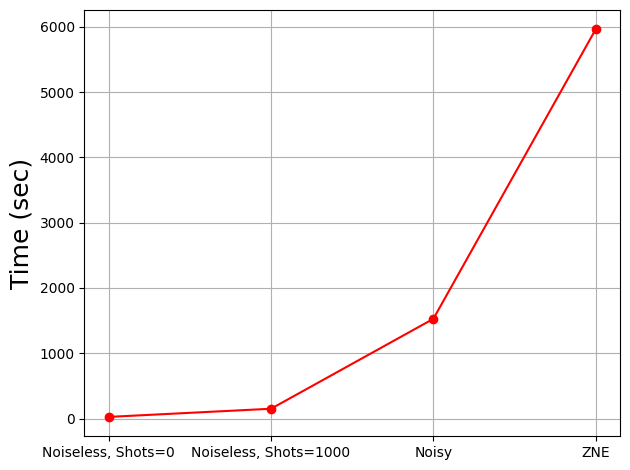

In [70]:
plt.plot([1, 2, 3, 4], times, 'o-', color='red')
plt.ylabel('Time (sec)', fontsize=18, rotation=90)
plt.xticks([1, 2, 3, 4], xtics)
plt.grid()
# plt.yscale('log')
# plt.xlim([-1,40])
# plt.yscale('log')
# plt.ylim([0.8,1.2])
plt.tight_layout()
plt.savefig("time_iteration_withZNE.png")
plt.show()

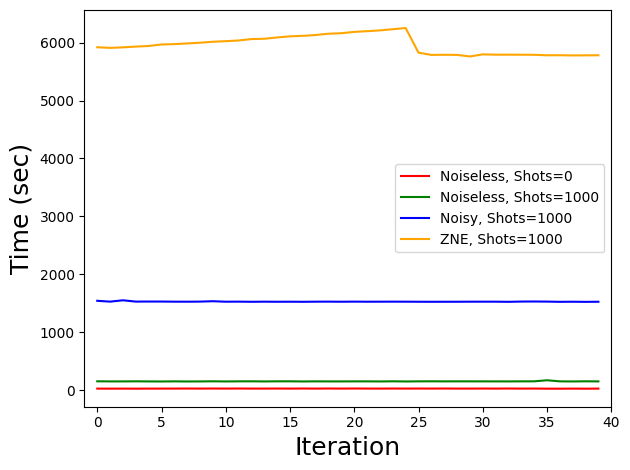

In [51]:
plt.plot(t_shots0, 'r')
plt.plot(t_shots1k, 'g')
plt.plot(t_noise, 'b')
plt.plot(t_zne, 'orange')
# plt.axhline(y = -1.274, color = 'black', linestyle = '--') 
plt.legend(["Noiseless, Shots=0", "Noiseless, Shots=1000", 
            "Noisy, Shots=1000", 
            "ZNE, Shots=1000", "True Value"])
plt.xlabel('Iteration', fontsize=18)
plt.ylabel('Time (sec)', fontsize=18, rotation=90)
plt.xlim([-1,40])
# plt.yscale('log')
# plt.ylim([0.8,1.2])
plt.tight_layout()
plt.savefig("time_iteration_withZNE.png")
plt.show()

## Cost estimation to run on Garnet

#### `Shots = 1000`

In [161]:
device_arn = "arn:aws:braket:::device/quantum-simulator/amazon/sv1"

@hybrid_job(device=device_arn, 
            local=False)
def run_vqe_hybrid_noiseless(shots=1000, max_iter=40):
    cost_tracker = Tracker().start()

    device = qml.device("brake.aws.qubit", backend="braket_sv", 
                        device_arn=device_arn, wires=qubits, shots=shots)
    print(device.name)
    converged_x = vqe_noiseless(device, shots=shots, max_iter=max_iter)
    cost_tracker.stop()

    # return converged_x
    return {"result": converged_x,
            "quantum task summary": cost_tracker.quantum_tasks_statistics(),
            "quantum task cost": cost_tracker.qpu_tasks_cost() + cost_tracker.simulator_tasks_cost(),
           }

In [358]:
job_sv_tracker = run_vqe_hybrid_noiseless(shots=1000, max_iter=1)

In [385]:
print(job_sv_tracker.arn, job_sv_tracker.name)

arn:aws:braket:us-east-1:574945598312:job/7c826721-7e46-4d43-82a5-78bf3ad417b1 run-vqe-hybrid-noiseless-1721163615987


In [118]:
job_sv_tracker = AwsQuantumJob("arn:aws:braket:us-east-1:574945598312:job/7c826721-7e46-4d43-82a5-78bf3ad417b1")

In [119]:
resource_data = job_sv_tracker.result()['quantum task summary']['arn:aws:braket:::device/quantum-simulator/amazon/sv1']

In [120]:
resource_data

{'shots': 1879000,
 'tasks': {'COMPLETED': 1879},
 'execution_duration': datetime.timedelta(seconds=23, microseconds=329000),
 'billed_execution_duration': datetime.timedelta(seconds=5637)}

In [121]:
n_shots = resource_data['shots']
n_task = resource_data['tasks']['COMPLETED']

In [122]:
n_shots

1879000

In [123]:
n_task

1879

In [162]:
cost_task = 0.30
cost_shot = 0.00145

cost_per_iteration = cost_task * n_task + n_shots * cost_shot
print("Cost to run each iteration on IQM Garnet in USD:", cost_per_iteration)

Cost to run each iteration on IQM Garnet in USD: 3288.2499999999995
